In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# MNIST 데이터셋을 불러와 훈련 데이터와 테스트 데이터로 나눈다.
# y_train과 y_test(각각의 숫자 라벨)는 사용하지 않기 때문에 _로 대체하여 무시
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()


In [3]:
# 데이터를 -1과 1 사이의 값으로 정규화한다.
X_train = (X_train.astype('float32') - 127.5) / 127.5
X_test = (X_test.astype('float32') - 127.5) / 127.5

# 데이터의 차원 조정: (60000, 28, 28) -> (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)  # 훈련 데이터의 차원 추가
X_test = np.expand_dims(X_test, axis=-1)    # 테스트 데이터의 차원 추가

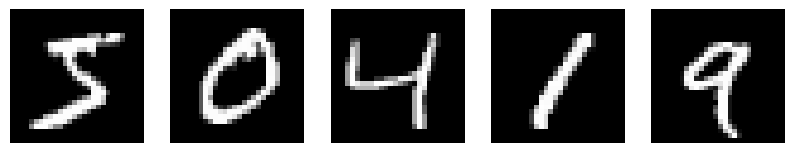

In [4]:
# 첫 번째 5개의 훈련 이미지를 시각화
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


In [6]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(512, activation='relu')
        self.dense3 = layers.Dense(1024, activation='relu')
        self.dense4 = layers.Dense(28 * 28, activation='tanh')  # 28x28 이미지로 출력

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return tf.reshape(x, (-1, 28, 28, 1))  # 이미지 형태로 변환

In [7]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.dense3 = layers.Dense(1, activation='sigmoid')  # 진짜/가짜 확률 출력

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

In [8]:
# GAN 모델 정의
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def call(self, inputs):
        generated_images = self.generator(inputs)
        validity = self.discriminator(generated_images)
        return validity

In [11]:
# 훈련 설정
batch_size = 256  # 배치 크기 정의
noise_dim = 100   # 노이즈 벡터 차원 정의

# 훈련 루프
@tf.function
def train_step(real_images):
    noise = tf.random.normal([batch_size, noise_dim])  # 랜덤 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(real_images)
        fake_output = discriminator(generated_images)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)  # 생성자 손실
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                      cross_entropy(tf.zeros_like(fake_output), fake_output)) * 0.5  # 구분자 손실

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 훈련 루프 (예시)
epochs = 50  # 총 에포크 수
for epoch in range(epochs):
    for i in range(len(X_train) // batch_size):
        real_images = X_train[i * batch_size:(i + 1) * batch_size]
        train_step(real_images)

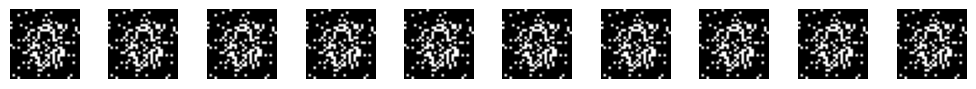

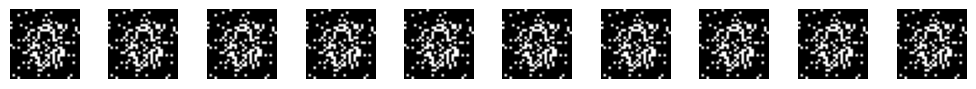

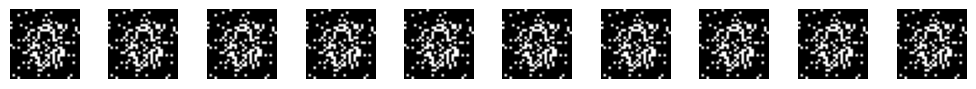

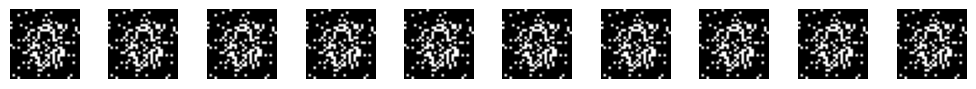

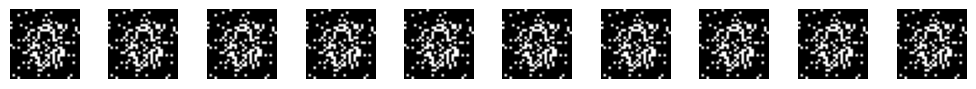

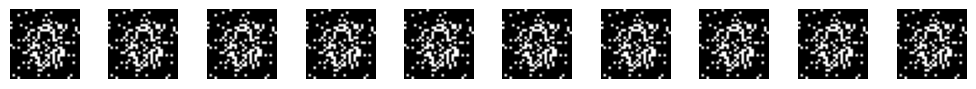

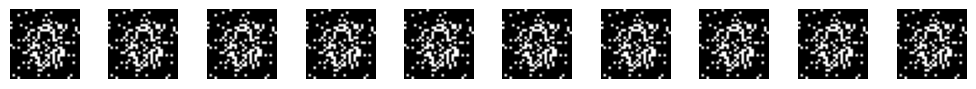

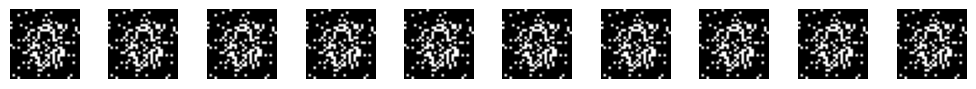

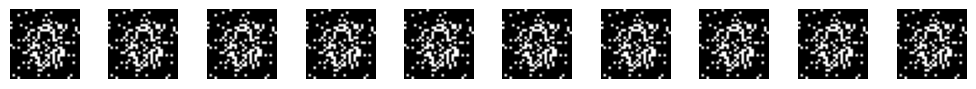

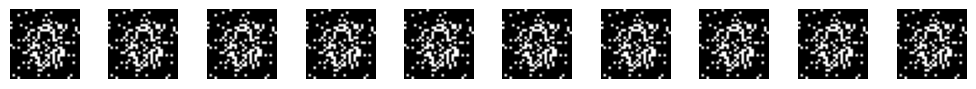

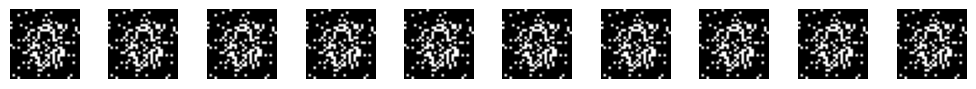

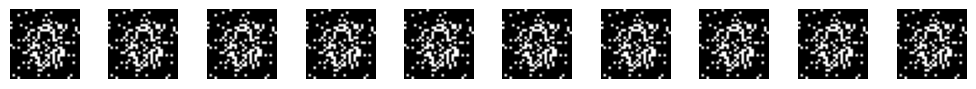

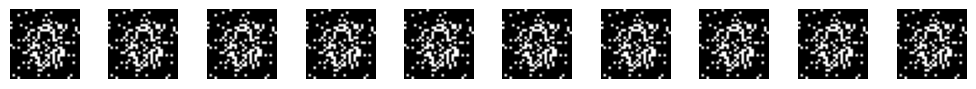

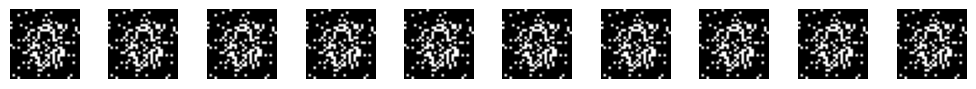

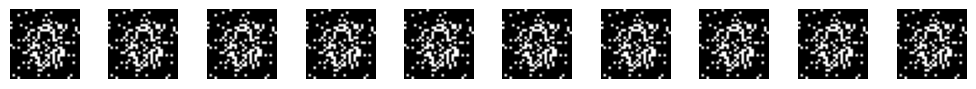

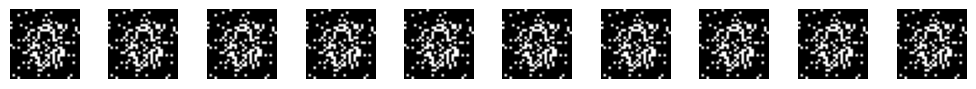

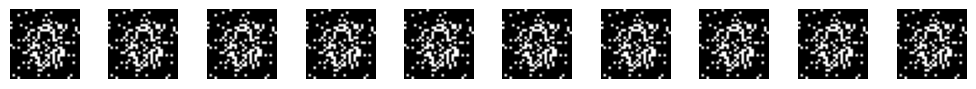

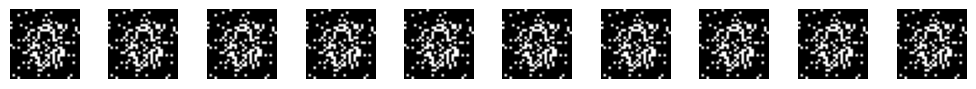

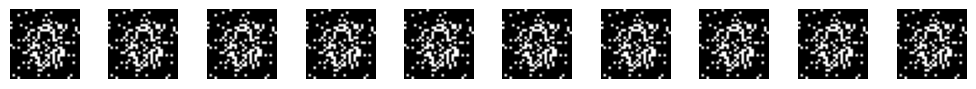

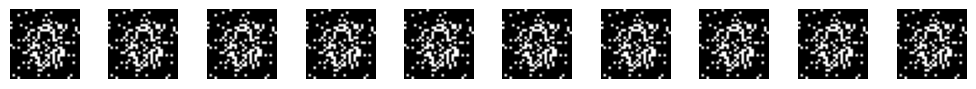

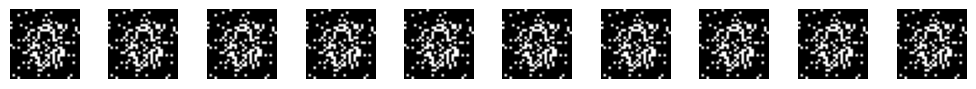

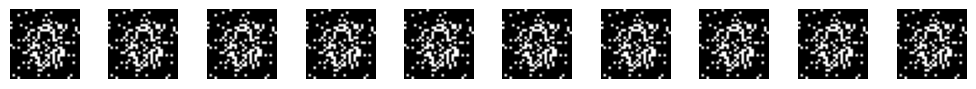

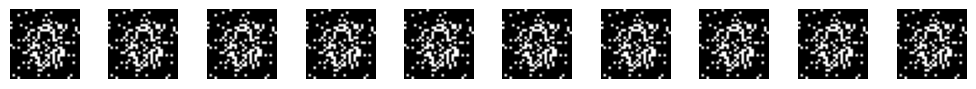

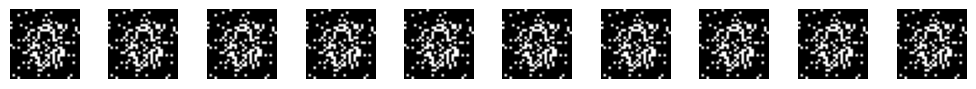

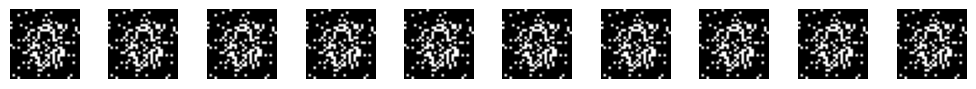

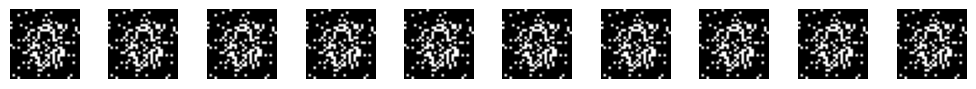

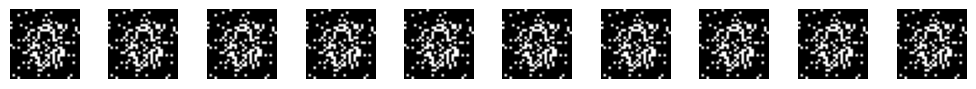

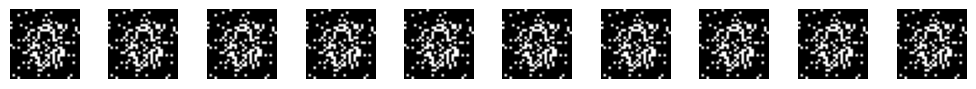

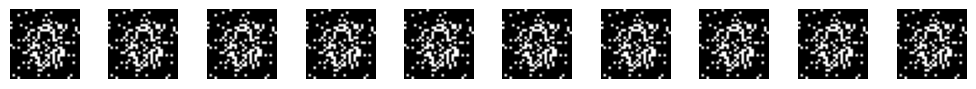

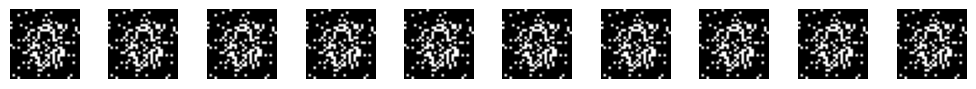

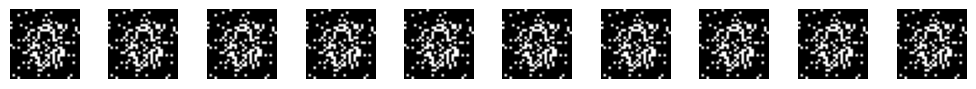

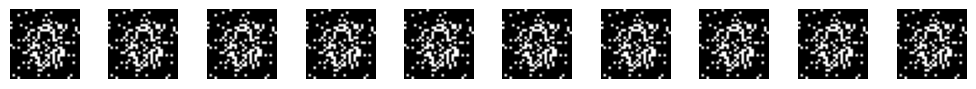

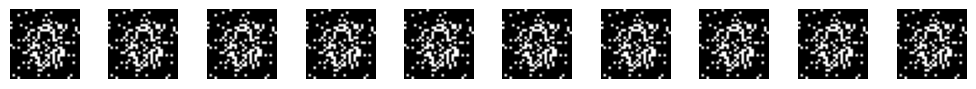

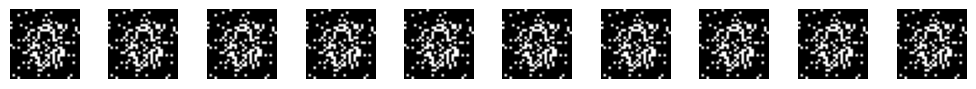

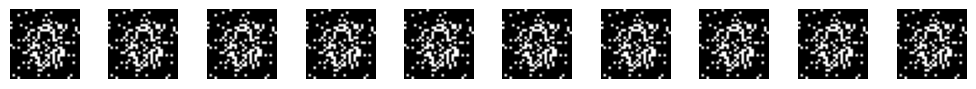

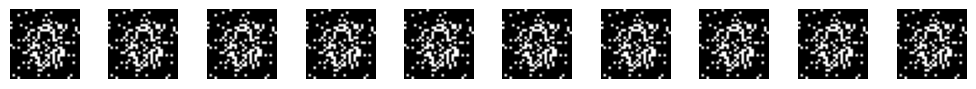

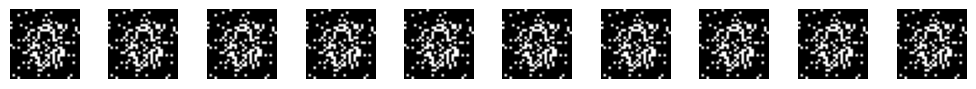

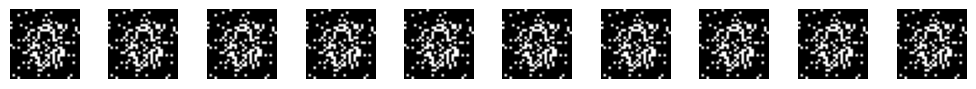

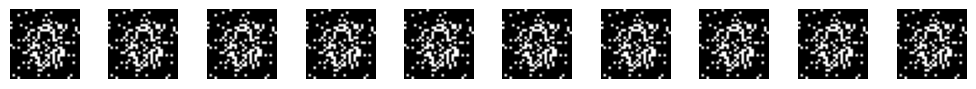

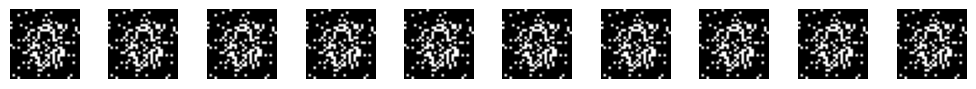

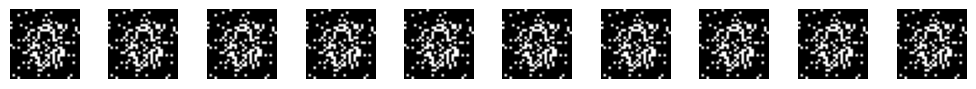

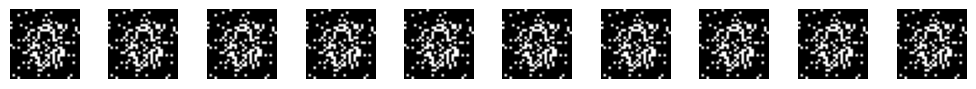

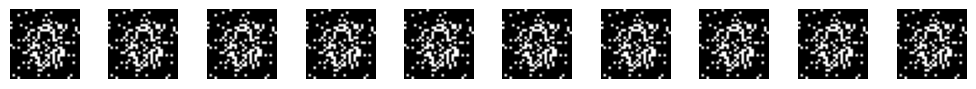

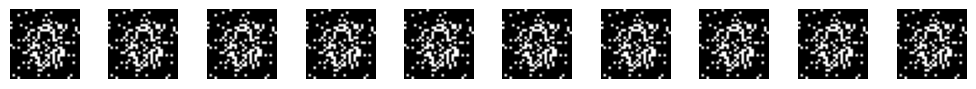

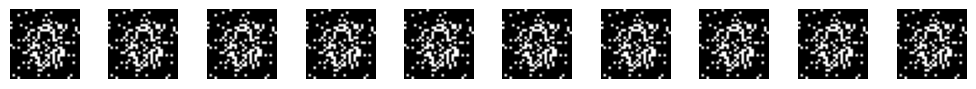

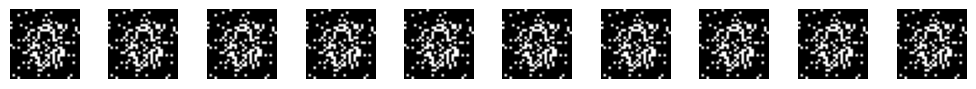

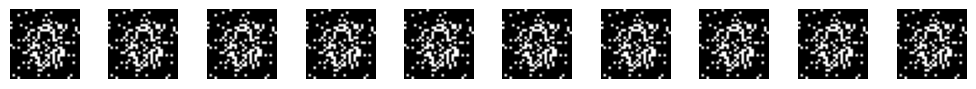

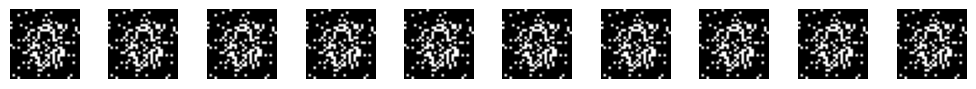

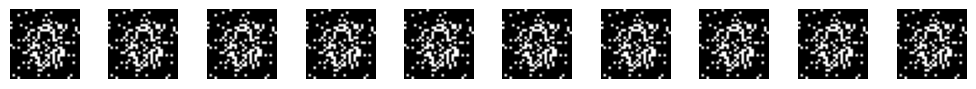

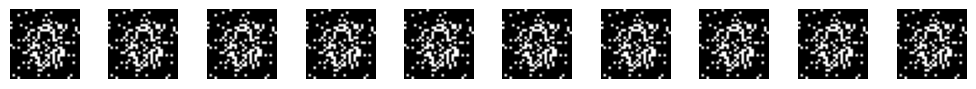

In [12]:
# 이미지 생성 및 평가 함수
def generate_and_display_images(model, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = tf.random.normal([examples, noise_dim])  # 랜덤 노이즈 생성
    generated_images = model(noise)  # 생성된 이미지
    generated_images = (generated_images.numpy() * 127.5 + 127.5).astype(np.uint8)  # 이미지 스케일 조정

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_epoch_{epoch}.png')  # 이미지 저장
    plt.show()

# 평가 및 이미지 생성 루프
for epoch in range(epochs):
    for i in range(len(X_train) // batch_size):
        real_images = X_train[i * batch_size:(i + 1) * batch_size]
        train_step(real_images)

    # 매 에포크마다 이미지 생성 및 표시
    generate_and_display_images(generator, epoch)